# Data Preparation

In [1]:
#import libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#smote data rebalancing
from imblearn.over_sampling import SMOTE, RandomOverSampler

#normalization
from sklearn import preprocessing

#classification
from sklearn.model_selection import train_test_split
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

# Function definitions

In [2]:
def meanImputation(df_train, df_test):
    """Data imputation using mean/mode of columns
    Following the methods described in: Razaliet al. (2020).
    Risk Factors of Cervical Cancer using Classification in Data Mining.
    Journal of Physics: Conference Series. 1529. 022102. 10.1088/1742-6596/1529/2/022102.

    Missing values for attribute that have integer data type were filled using the sample mean
    while boolean were filled using the sample mode. The mean/mode are calculated on the training
    set and the from fitting are saved and then used when predicting on the test set. 
    """ 
    # replace NaN with mode for columns with dtype bool
    for label, col in df_train.iteritems():
        if label in bool_columns:
            columns_mode = col.mode()
            df_train[label] = col.fillna(columns_mode[0])
            # impute test set with training set mean
            df_test[label] = col.fillna(columns_mode[0])

            #convert column to bool while we're at it
            df_train[label] = df_train[label].astype('bool')
            df_test[label] = df_test[label].astype('bool')
    
    float_columns = df_train.select_dtypes(include=['float64']).columns
    
    # replace NaN with mean for columns with dtype float
    for col in float_columns:
        columns_mean = df_train[col].mean()
        df_train[col] = df_train[col].fillna(columns_mean)
        df_test[col] = df_test[col].fillna(columns_mean)
    
    return df_train, df_test

In [3]:
# Fitting an explainabe boosting machine
# More information on EBMs can be found here: https://github.com/interpretml/interpret
def EBM(X_train, y_train, X_test, y_test, showModel):
    # fit an ebm
    # no interactions between features allowed to simplify explainability
    ebm = ExplainableBoostingClassifier(interactions=0)
    ebm.fit(X_train, y_train)

    if showModel:
        # understand the model
        ebm_global = ebm.explain_global()
        show(ebm_global)

        # understand individual predictions
        ebm_local = ebm.explain_local(X_test, y_test)
        show(ebm_local)
    
    # return the mean accuracy on the given test data and labels
    acc = ebm.score(X_test, y_test)
    
    # return predictions
    pred = ebm.predict(X_test)
    
    return acc, ebm, pred

# Loading Dataset

In [4]:
# https://archive-beta.ics.uci.edu/ml/datasets/cervical+cancer+risk+factors
"""
The dataset was collected at 'Hospital Universitario de Caracas' in Caracas, Venezuela.
The dataset comprises demographic information, habits, and historic medical records of 858 patients.
Several patients decided not to answer some of the questions because of privacy concerns (missing values).
"""

rf = pd.read_csv('risk_factors_cervical_cancer.csv',encoding='utf8')

In [5]:
#rf.info()

# Covert data to usable datatypes

In [6]:
# replace missing values with NaN
rf = rf.replace('?',np.nan)

# covert everything to float64, some classes will be converted to bool once missing values are taken care of
for label, col in rf.iteritems():
    rf[label] = pd.to_numeric(col, errors='coerce')

# TODO: some things are still int after this and object types get transformed to bool automatically. But NaN values
# are not falsly converted to True so that should be okay.

# Examine data

## Check missing values per column

In [7]:
percent_missing = rf.isnull().sum() * 100 / len(rf)
missing_value_df = pd.DataFrame({'column_name': rf.columns,
                                 'percent_missing': percent_missing})
print("On average {} % are missing".format(missing_value_df['percent_missing'][:-4].mean()))
missing_value_df

On average 13.192016317016318 % are missing


,column_name,percent_missing
Age,Age,0.000000
Number of sexual partners,Number of sexual partners,3.030303
First sexual intercourse,First sexual intercourse,0.815851
Num of pregnancies,Num of pregnancies,6.526807
Smokes,Smokes,1.515152
Smokes (years),Smokes (years),1.515152
Smokes (packs/year),Smokes (packs/year),1.515152
Hormonal Contraceptives,Hormonal Contraceptives,12.587413
Hormonal Contraceptives (years),Hormonal Contraceptives (years),12.587413
IUD,IUD,13.636364


In [8]:
# remove columns with more than 20% missing
selected_columns = missing_value_df.loc[missing_value_df['percent_missing'] >= 20].iloc[:, 0]
print("The following columns were removed: \n{}".format(selected_columns[:]))

for col in selected_columns:
    rf = rf.drop([col], axis=1)

The following columns were removed: 
STDs: Time since first diagnosis    STDs: Time since first diagnosis
STDs: Time since last diagnosis      STDs: Time since last diagnosis
Name: column_name, dtype: object


## Check missing values per row

We chose to exclude rows that have more than 15% of data missing. 

In [9]:
missing_count = []
for idx in range(len(rf)):
    missing = rf.loc[[idx]].isna().sum().sum()
    missing_count.append(missing)

removed = 0
for idx, val in enumerate(missing_count):
    # Remove all rows where more than 15% of the data are missing
    if val >= len(rf.columns)*0.15:
        rf = rf.drop(idx)
        removed+=1
print("{} number of rows were removed".format(removed))

106 number of rows were removed


## Investigate class imbalance

In [10]:
# get number of patients per group
rf.groupby('Biopsy').count()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology
Biopsy,,,,,,,,,,,,,,,,,,,,,
0,699,686,693,658,691,691,691,687,687,686,...,699,699,699,699,699,699,699,699,699,699
1,53,52,53,47,52,52,52,53,53,51,...,53,53,53,53,53,53,53,53,53,53


## Investigate STDs (number) vs STDs: Number of diagnosis

In [11]:
# check if STDs (number) and STDs: Number of diagnosis are the same
STD_comparison = np.where((rf['STDs (number)']==rf['STDs: Number of diagnosis']), True, False)

# check manual calculation with STDs(number) if STDS (number) and STDs: Number of diagnosis not the same
if not STD_comparison.all():
    # create a new column with the sum of all STDs
    rf['STDs (number manual)'] = (rf['STDs:condylomatosis'] + rf['STDs:cervical condylomatosis'] +
        rf['STDs:vaginal condylomatosis'] + rf['STDs:vulvo-perineal condylomatosis'] +
        rf['STDs:syphilis'] + rf['STDs:pelvic inflammatory disease'] +
        rf['STDs:genital herpes'] + rf['STDs:molluscum contagiosum'] +
        rf['STDs:AIDS'] + rf['STDs:HIV'] +
        rf['STDs:Hepatitis B'] + rf['STDs:HPV'])
    
    # if they're the same drop the new column again
    manual_comp = np.where((rf['STDs (number)']==rf['STDs (number manual)']), True, False)
    if manual_comp.all():
        rf = rf.drop(['STDs (number manual)'], axis=1)

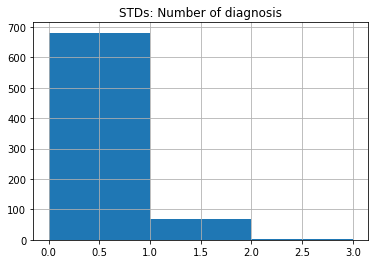

In [12]:
# STDs: Number of diagnosis is also not the same as just STDs
STD_comparison = np.where((rf['STDs']==rf['STDs: Number of diagnosis']), True, False).all() #=False

# is STDs: Number of diagnosis a encoded value?
minimum = rf['STDs: Number of diagnosis'].min() #=0
maximum = rf['STDs: Number of diagnosis'].max() #=3
# unlikely that it's the diagnosis code if the max is 3

# plot in histogram
ax = rf.hist(column=["STDs: Number of diagnosis"], bins=maximum)

# we don't know exactly what this column
# as our goal is to create a transparent model we decided to exclude the column
rf = rf.drop(['STDs: Number of diagnosis'], axis=1)

# Splitting the dataset into training and testing sets

In [13]:
# using oversampled data
# split dataset in features and target variable
feature_cols = rf.columns[0:len(rf.columns)-4]
X = rf[feature_cols] # Features
y = rf.Biopsy # Target variable

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=1) # 80% training and 20% test

## Data imputation
Method 1:
Following the methods described in:
Razali, Nazim & Mostafa, Salama & Mustapha, Aida & Abd Wahab, Mohd Helmy & Ibrahim, Nurul. (2020). Risk Factors of Cervical Cancer using Classification in Data Mining. Journal of Physics: Conference Series. 1529. 022102. 10.1088/1742-6596/1529/2/022102. 

"Missing values for attribute that have integer data type were filled using the sample mean while boolean
were filled using the sample mode."

Method 2:
Missing values are filled with a constant value that has meaning in the data otherwise. -1 was chosen.

In [14]:
# imputation on X_train and X_test
# minority class is not missing any data, known from analysis before

# bool columns in dataframe
global bool_columns
bool_columns = ['Smokes','Hormonal Contraceptives', 'IUD', 'STDs',
                'STDs:condylomatosis', 'STDs:cervical condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease', 
                'STDs:genital herpes', 'STDs:molluscum contagiosum',
                'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV',
                'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx']


# imputation method 2: use unique values that don't/can't otherwise exist in the df. Chosen value: -1
X_train_unique_imputation = X_train.copy()
X_test_unique_imputation = X_test.copy()

X_train_unique_imputation.fillna(-1, inplace=True)
X_test_unique_imputation.fillna(-1, inplace=True);

In [15]:
# Check minority class imbalance
y_train.value_counts()

0    559
1     42
Name: Biopsy, dtype: int64

In [16]:
y_test.value_counts()

0    140
1     11
Name: Biopsy, dtype: int64

# Oversampling of X_train, y_train

## SMOTE oversampling - training data

In [19]:
# oversampling using synthetic minority oversampling technique (SMOTE)
# see: Chawla N V, Bowyer K W, Hall L O and Kegelmeyer W P 2002 Journal of Artificial Intelligence Research 16 321-357

# for reproducibility purposes
seed = 100
# SMOTE number of neighbors
k = 1

sm = SMOTE(sampling_strategy='auto', k_neighbors=k, random_state=seed)
X_train_smote, y_train_smote = sm.fit_resample(X_train_unique_imputation, y_train)

print("Minority class count after SMOTE oversampling: \n{}".format(y_train_smote.value_counts()))

Minority class count after SMOTE oversampling: 
0    559
1    559
Name: Biopsy, dtype: int64


# Classification

## SMOTE Oversampling, unique value imputation

In [26]:
ebm_sm = ExplainableBoostingClassifier(interactions=0)
ebm_sm.fit(X_train_smote, y_train_smote)

ExplainableBoostingClassifier(feature_names=['Age', 'Number of sexual partners',
                                             'First sexual intercourse',
                                             'Num of pregnancies', 'Smokes',
                                             'Smokes (years)',
                                             'Smokes (packs/year)',
                                             'Hormonal Contraceptives',
                                             'Hormonal Contraceptives (years)',
                                             'IUD', 'IUD (years)', 'STDs',
                                             'STDs (number)',
                                             'STDs:condylomatosis',
                                             'STDs:cervical condylomatosis',
                                             'STDs:vaginal condylomatosis',
                                             'STDs...
                                             'continuous', 'continuous',
 

In [27]:
# show local explanations
indices = [23, 31, 55, 64, 106, 113, 127, 137, 144]
ebm_local_sm = ebm_sm.explain_local(X_test_unique_imputation.iloc[indices], y_test.iloc[indices])

show(ebm_local_sm)

<!-- http://127.0.0.1:7001/140732107064272/ -->

In [28]:
ebm_sm_global = ebm_sm.explain_global()
show(ebm_sm_global)

<!-- http://127.0.0.1:7001/140732107349584/ -->

# Results

In [ ]:
roc_smote = roc_auc_score(y_test, pred_smote)
prec_rec_f1_supp_smote = precision_recall_fscore_support(y_test, pred_smote, average='macro')
print("SMOTE oversampling: \naccuracy: {}\nROC AUC:{}\nprecision:{} ".format(acc_smote, roc_smote, prec_rec_f1_supp_smote[0]))

confusion_matrix(y_test, pred_smote)